# Construcción de Tipologías: Clústers

In [1]:
#from pyspark import SparkContext
#sc = SparkContext()
#from pyspark.sql import SQLContext
#sqlContext=SQLContext(sc)

In [2]:
bd5 = sqlContext.read.format(
    "com.databricks.spark.csv"
).option("header", "true").load("bd5.csv", inferSchema=True)
sqlContext.registerDataFrameAsTable(bd5, "bd5")

## Reducción de dimensionalidad: PCA

In [3]:
from pyspark.ml.feature import VectorAssembler

a1  = VectorAssembler(
    inputCols=['DEP_DELAY','DISTANCE','DAY_OF_WEEK',
               'CRS_DEP_TIME','Horario','LogD'],
    outputCol='features')

bd6 = a1.transform(bd5)

In [4]:
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=True)
scalerModel = scaler.fit(bd6)
bd6std = scalerModel.transform(bd6)

pca2=PCA(k=2,inputCol='scaledFeatures',outputCol='pca_scaledfeatures')
model2=pca2.fit(bd6std)
bd6pca2=model2.transform(bd6std)


## Clústers - K-Means

In [5]:
from pyspark.ml.clustering import KMeans

#4 clústers
kmeans=KMeans(k=4,seed=123,featuresCol="pca_scaledfeatures",maxIter=10, predictionCol="Cluster")
model3=kmeans.fit(bd6pca2)

bd6Kmeans = model3.transform(bd6pca2)

In [6]:
bd6Kmeans.select('pca_scaledfeatures','Cluster').show()

+--------------------+-------+
|  pca_scaledfeatures|Cluster|
+--------------------+-------+
|[-2.1481167921052...|      3|
|[-2.0580632199285...|      3|
|[-1.6945582244580...|      3|
|[-1.5824805413590...|      3|
|[-0.5458187260638...|      2|
|[-1.8750035509122...|      2|
|[-0.5990634736882...|      2|
|[1.69894829802062...|      0|
|[1.53427565410245...|      0|
|[0.32786666838261...|      1|
|[-2.3865997873638...|      2|
|[0.58471397283816...|      1|
|[-0.6262974930119...|      2|
|[1.56173170587968...|      0|
|[0.43770513210056...|      1|
|[0.31602276092994...|      1|
|[-2.1216234060703...|      2|
|[1.18761526357020...|      0|
|[0.87239689347422...|      0|
|[2.36627932235609...|      0|
+--------------------+-------+
only showing top 20 rows



In [7]:
bd6Kmeans.groupBy('Cluster').count().show()

+-------+-----+
|Cluster|count|
+-------+-----+
|      0| 7447|
|      1| 6579|
|      2|10469|
|      3| 5971|
+-------+-----+



## Caracterización de los Clústers

In [8]:
centers = model3.clusterCenters()
centers

[array([ 1.21396125,  1.09933938]),
 array([ 1.366189  , -1.22638355]),
 array([-1.08535624, -0.7004685 ]),
 array([-1.15983879,  1.24042271])]

In [11]:
sqlContext.registerDataFrameAsTable(bd6Kmeans, "bd6Kmeans")

g3 = sqlContext.sql("select Cluster, count(*) as n, \
               avg(Dep_Delay) as DepDelay, \
               avg(Distance) as Distance, \
               avg(Day_Of_Week) as DayOfWeek, \
               avg(CRS_Dep_Time) as CRSDepTime, \
               avg(Horario) as Horario, \
               avg(LogD) as LogD \
               from bd6Kmeans group by Cluster")
g3.toPandas()

,Cluster,n,DepDelay,Distance,DayOfWeek,CRSDepTime,Horario,LogD
0,0,7447,5.645361,1183.239157,3.937290,770.190412,1.460991,3.046359
1,1,6579,24.367989,1645.911385,4.015656,1579.015504,2.973400,3.209206
2,2,10469,25.647531,619.848314,4.024644,1709.847454,3.397077,2.756240
3,3,5971,9.005862,384.425557,3.988277,1117.684140,1.902026,2.557431


## Representación Gráfica

In [10]:
#Extraemos las componentes

from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

p1=udf(lambda v:float(v[0]),FloatType())
p2=udf(lambda v:float(v[1]),FloatType())

bd6Kmeans=bd6Kmeans.withColumn('pca1',p1('pca_scaledfeatures')).withColumn('pca2',p2('pca_scaledfeatures'))

pdf6 = bd6Kmeans.sample(False, 0.1, 0).select('pca1','pca2','Cluster').toPandas()
pdf6

,pca1,pca2,Cluster
0,0.631540,-1.897467,1
1,0.345410,-0.418438,1
2,1.883883,-0.988366,1
3,-1.292474,2.581859,3
4,0.756372,-1.708365,1
5,0.388009,1.758872,0
6,-0.862525,-1.175283,2
7,-0.353454,0.952002,3
8,2.628615,1.249931,0
9,-0.981423,-1.445900,2


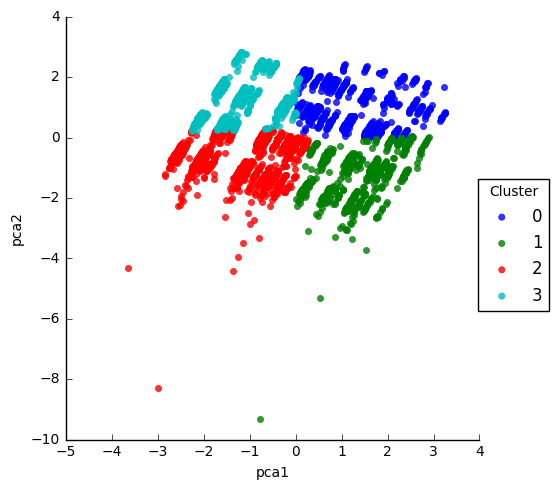

In [12]:
import seaborn as sns
%matplotlib inline

sns.lmplot(x="pca1", y="pca2", hue="Cluster", fit_reg=False, data=pdf6)